# Cabeçalho - TODO (escrever bonitinho)

## Resumo do trabalho - TODO (escrever bonitinho)

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, scoring=metrica, cv=n_folds, n_jobs=1)
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    resultados.sort_values(by='rank_test_score', inplace=True)
    resultados.sort_values(by='rank_test_score', inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dataset = dataset.merge(fat_df, how='left', on='Country', copy=False)

In [36]:
dataset = dataset.merge(protein_df, how='left', on='Country', copy=False)

In [37]:
dataset = dataset.merge(kcal_df, how='left', on='Country', copy=False)

In [38]:
dataset = dataset.merge(quantity_kg_df, how='left', on='Country', copy=False)

In [39]:
dataset.shape

(170, 101)

## Analisando o dado

**TODO: testar pandas-profile**

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Columns: 101 entries, Country to Vegetables_quantity
dtypes: float64(98), object(3)
memory usage: 135.5+ KB


In [41]:
dataset.dtypes.value_counts()

float64    98
object      3
dtype: int64

In [42]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [43]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [44]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",...,Pulses_quantity,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,0.001035,20.695714,4.138451,0.000450,...,0.537131,0.091011,5.335371,0.201946,0.095846,2.799115,0.117474,37.814834,0.851554,6.085912
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,0.009569,8.002713,3.287462,0.004039,...,0.601111,0.121898,5.571355,0.189239,0.379936,1.545951,0.146143,5.852943,0.445335,3.560148
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,5.018200,0.026200,0.000000,...,0.000000,0.000000,0.679600,0.004200,0.000000,0.366600,0.000000,23.113200,0.091500,0.857000
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.000000,14.885800,1.674225,0.000000,...,0.129650,0.016500,2.023825,0.083325,0.000000,1.721025,0.020750,33.552775,0.507700,3.616500
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,0.000000,20.943050,3.312350,0.000000,...,0.300800,0.042550,3.108650,0.159450,0.000000,2.601650,0.079950,37.900700,0.774450,5.028100
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,0.000000,26.866950,6.227575,0.000000,...,0.734900,0.123150,5.745875,0.261800,0.000000,3.782150,0.148650,42.762775,1.070900,7.801650
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,0.097600,36.901800,14.937300,0.051100,...,3.483800,0.662600,27.712800,1.282300,3.067700,9.725900,0.756900,48.258500,2.202600,19.299500


In [45]:
dataset.isnull().sum()

Country                        0
Obesity                        3
Undernourished                 7
Confirmed                      9
Deaths                         9
                              ..
Sugar & Sweeteners_quantity    0
Treenuts_quantity              0
Vegetal Products_quantity      0
Vegetable Oils_quantity        0
Vegetables_quantity            0
Length: 101, dtype: int64

In [46]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [47]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [48]:
dataset.shape

(161, 101)

In [49]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [50]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [51]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [52]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [53]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [54]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [55]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [56]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [57]:
dataset.isnull().sum().unique()

array([0])

## Golden features

In [58]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [59]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    print (t, golden_features_list)

Confirmed Confirmed                            1.000000
Recovered                            0.823831
Active                               0.730086
Deaths                               0.717421
Animal Products_kcal                 0.482963
Animal Products_protein              0.471756
Animal Products_quantity             0.454655
Eggs_kcal                            0.429222
Milk - Excluding Butter_protein      0.423439
Obesity                              0.419346
Animal fats_quantity                 0.405072
Milk - Excluding Butter_kcal         0.401307
Animal fats_kcal                     0.395164
Stimulants_kcal                      0.386813
Eggs_protein                         0.384428
Milk - Excluding Butter_quantity     0.379119
Alcoholic Beverages_kcal             0.369625
Animal fats_fat                      0.350306
Animal Products_fat                  0.344300
Meat_kcal                            0.341846
Treenuts_kcal                        0.336915
Meat_protein            

**TODO: fazer uns gráficos das correlações (golden features)**

## Remover outliers

**TODO: colocar uns gráficos de boxplot por country**

In [60]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.01)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

2 outliers detectados


## Separando features das targets

**TODO: melhor usar obesity e undernourished como features?**

In [61]:
targets = ['Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active']
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [62]:
cols = dataset.columns.to_list()

In [63]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [64]:
x_features.head()

,Country,Population,Unit (all except Population),Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,Eggs_fat,"Fish, Seafood_fat",...,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity,is outlier
0,Afghanistan,38042000.0,%,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,...,0.0574,0.8802,0.3078,0.0,1.3489,0.0770,40.5645,0.5345,6.7642,0
1,Albania,2858000.0,%,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,...,0.0008,1.8096,0.1055,0.0,1.5367,0.1515,31.2304,0.3261,11.7753,0
2,Algeria,43406000.0,%,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,...,0.0557,4.1340,0.2216,0.0,1.8342,0.1152,40.3651,1.0310,11.6484,0
3,Angola,31427000.0,%,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,...,0.0009,18.1102,0.0508,0.0,1.8495,0.0061,45.0722,0.6463,2.3041,0
4,Antigua and Barbuda,97000.0,%,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,...,0.1524,1.4522,0.1564,0.0,3.8749,0.0253,33.3233,0.8102,5.4495,0


In [65]:
del x_features['Unit (all except Population)']

In [66]:
x_features.dtypes.value_counts()

float64    93
int64       1
object      1
dtype: int64

In [67]:
x_features_orig = x_features.copy()

In [68]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

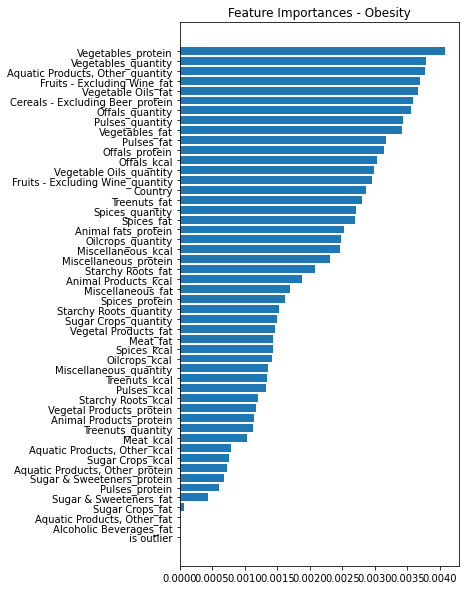

<Figure size 432x288 with 0 Axes>

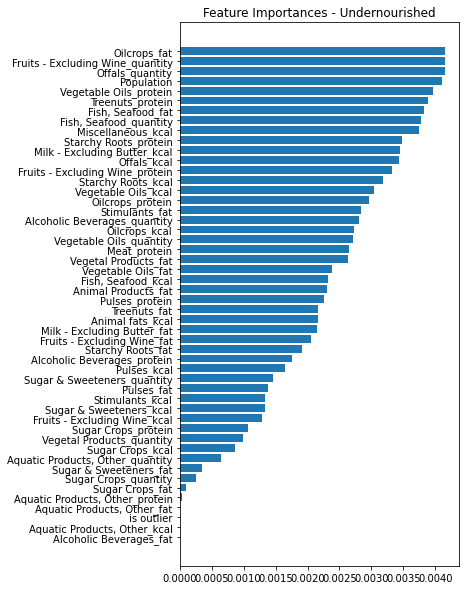

<Figure size 432x288 with 0 Axes>

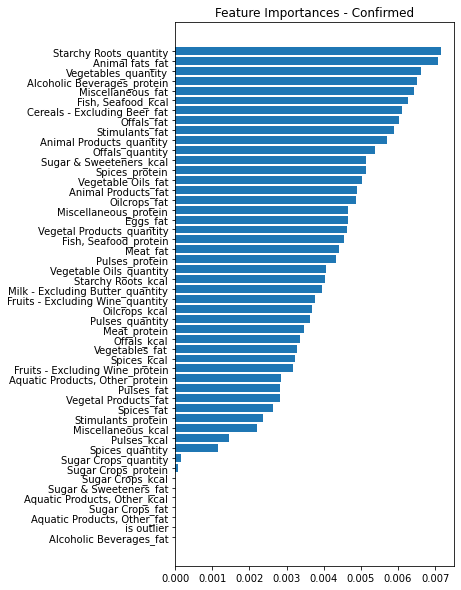

<Figure size 432x288 with 0 Axes>

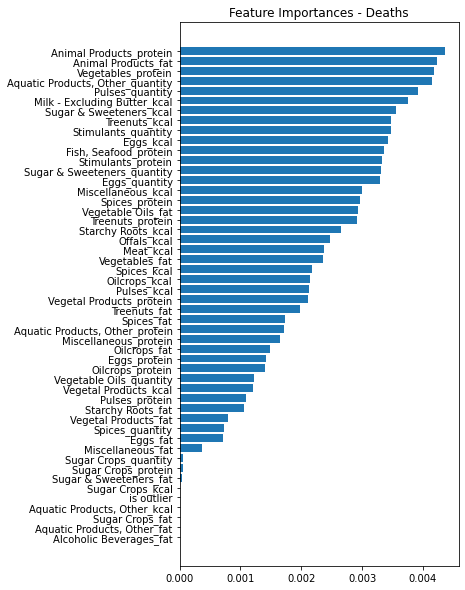

<Figure size 432x288 with 0 Axes>

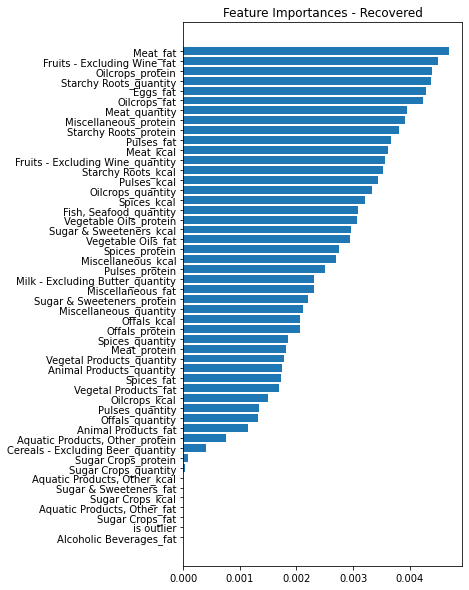

<Figure size 432x288 with 0 Axes>

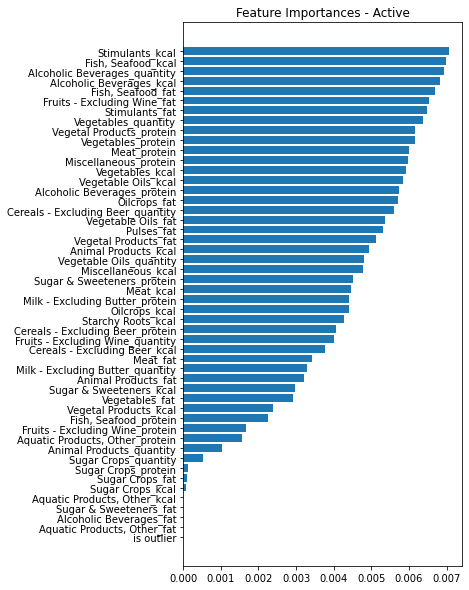

In [69]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

**TODO: colorir gráfico de acordo com sinal (negativo ou positivo) da correlação**

**TODO: testar quantas features usar, fazendo sensibilidade**

<Figure size 432x288 with 0 Axes>

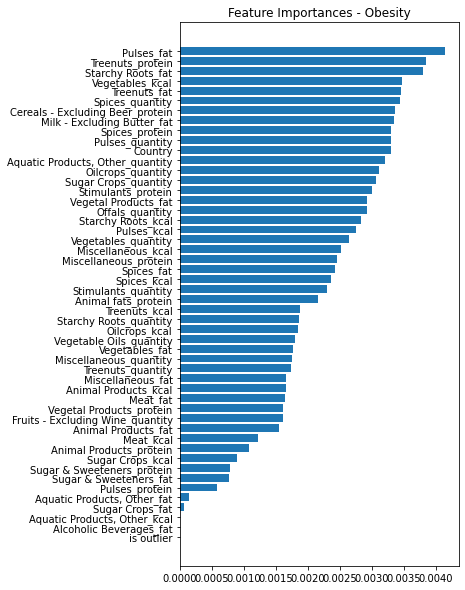

Pulses_fat 0.004149938186087361
Treenuts_protein 0.00384778483405036
Starchy Roots_fat 0.0038076675943806053
Vegetables_kcal 0.00347001153408835
Treenuts_fat 0.0034517913603334385
Spices_quantity 0.0034396439896015756
Cereals - Excluding Beer_protein 0.0033662138853225413
Milk - Excluding Butter_fat 0.00335313688911028
Spices_protein 0.0033094348529714938
Pulses_quantity 0.0033043112741393426
Country 0.0033004063172758966
Aquatic Products, Other_quantity 0.003207102476695667
Oilcrops_quantity 0.003113675135819107
Sugar Crops_quantity 0.0030691114294261516
Stimulants_protein 0.0029978004948751726
Vegetal Products_fat 0.002931915900618754
Offals_quantity 0.00293139681172957
Starchy Roots_kcal 0.0028278946157467466
Pulses_kcal 0.0027570270877775352
Vegetables_quantity 0.002646621118604086
Miscellaneous_kcal 0.0025234288267180654
Miscellaneous_protein 0.0024638139280602567
Spices_fat 0.0024265942795203823
Spices_kcal 0.0023716523710363927
Stimulants_quantity 0.0023090132264586742
Animal fa

<Figure size 432x288 with 0 Axes>

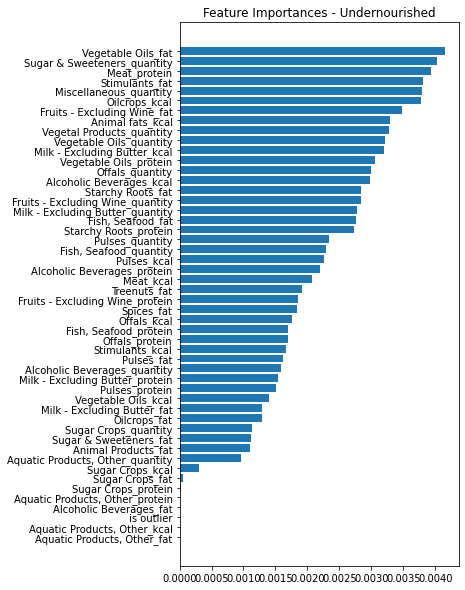

Vegetable Oils_fat 0.004158483069522028
Sugar & Sweeteners_quantity 0.004024224105642274
Meat_protein 0.003939045369225847
Stimulants_fat 0.0038129613949927726
Miscellaneous_quantity 0.003796950069190133
Oilcrops_kcal 0.003774365045257932
Fruits - Excluding Wine_fat 0.00348252661555805
Animal fats_kcal 0.003292815569757111
Vegetal Products_quantity 0.003279820227312798
Vegetable Oils_quantity 0.0032178386377098205
Milk - Excluding Butter_kcal 0.003196509436210274
Vegetable Oils_protein 0.0030597112982621677
Offals_quantity 0.0029956709920923945
Alcoholic Beverages_kcal 0.0029724380402445768
Starchy Roots_fat 0.002846582729230298
Fruits - Excluding Wine_quantity 0.0028358994671087295
Milk - Excluding Butter_quantity 0.002773286880659526
Fish, Seafood_fat 0.002754095260131129
Starchy Roots_protein 0.0027321273033977305
Pulses_quantity 0.0023446113548215904
Fish, Seafood_quantity 0.0022854237271891457
Pulses_kcal 0.002266536479239911


<Figure size 432x288 with 0 Axes>

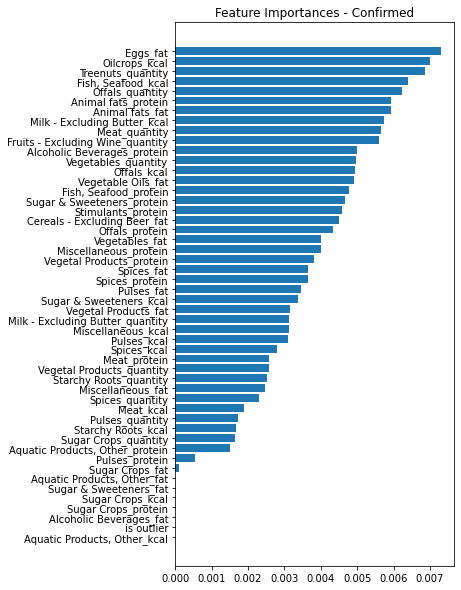

Eggs_fat 0.00730145087619882
Oilcrops_kcal 0.006999757580547779
Treenuts_quantity 0.006870782687898802
Fish, Seafood_kcal 0.006392844952433713
Offals_quantity 0.006238686536227203
Animal fats_protein 0.005939997821581341
Animal fats_fat 0.005927874473723083
Milk - Excluding Butter_kcal 0.005749052618725139
Meat_quantity 0.005651954471935472
Fruits - Excluding Wine_quantity 0.005597787651081991
Alcoholic Beverages_protein 0.004999830208103473
Vegetables_quantity 0.0049726760693634105
Offals_kcal 0.004944939503003318
Vegetable Oils_fat 0.0049001870389902245
Fish, Seafood_protein 0.004768242982918958
Sugar & Sweeteners_protein 0.004656234977875417
Stimulants_protein 0.004574535515498834
Cereals - Excluding Beer_fat 0.004509907658958569
Offals_protein 0.004342586879467455
Vegetables_fat 0.004010502076634245
Miscellaneous_protein 0.004005225394217948
Vegetal Products_protein 0.003823894947674204
Spices_fat 0.003649963688044562
Spices_protein 0.0036422262566808846


<Figure size 432x288 with 0 Axes>

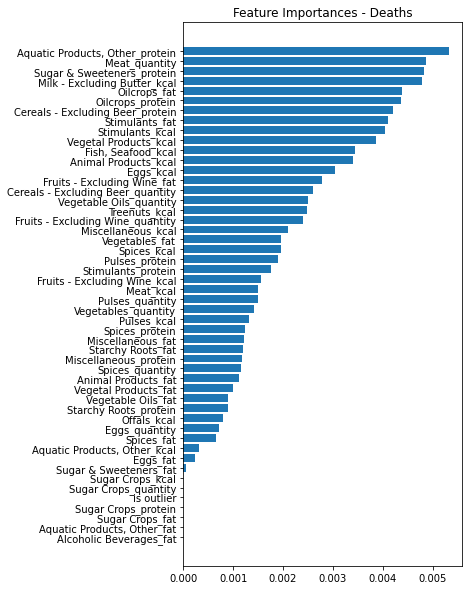

Aquatic Products, Other_protein 0.005322202651440039
Meat_quantity 0.0048713714569183116
Sugar & Sweeteners_protein 0.004823379244119677
Milk - Excluding Butter_kcal 0.004776646533529466
Oilcrops_fat 0.004383555982033836
Oilcrops_protein 0.004363649302397137
Cereals - Excluding Beer_protein 0.004203721585243915
Stimulants_fat 0.004100443522672203
Stimulants_kcal 0.004040190605737616
Vegetal Products_kcal 0.003860002509366547
Fish, Seafood_kcal 0.0034463114545768563
Animal Products_kcal 0.003397176878178377
Eggs_kcal 0.0030368880928681864
Fruits - Excluding Wine_fat 0.002770909303158447
Cereals - Excluding Beer_quantity 0.0025968710044430776
Vegetable Oils_quantity 0.002497674349056289
Treenuts_kcal 0.0024809245825725764
Fruits - Excluding Wine_quantity 0.0023963830194763383
Miscellaneous_kcal 0.002097351618975504
Vegetables_fat 0.0019663010233398437
Spices_kcal 0.001965433771446898
Pulses_protein 0.0018914357750076576
Stimulants_protein 0.0017574991713131065


<Figure size 432x288 with 0 Axes>

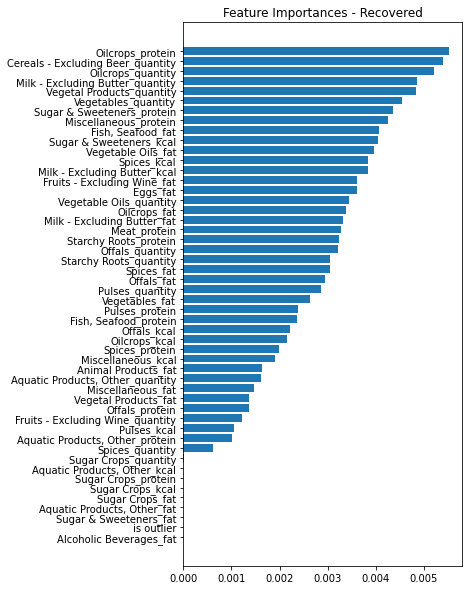

Oilcrops_protein 0.005516712398158668
Cereals - Excluding Beer_quantity 0.005392084415632096
Oilcrops_quantity 0.005205998305979026
Milk - Excluding Butter_quantity 0.004850925757486187
Vegetal Products_quantity 0.004826677062031547
Vegetables_quantity 0.004542038062484136
Sugar & Sweeteners_protein 0.0043508347211319714
Miscellaneous_protein 0.004249342278452495
Fish, Seafood_fat 0.00406130886489296
Sugar & Sweeteners_kcal 0.004052842362623297
Vegetable Oils_fat 0.0039539425791967325
Spices_kcal 0.0038324870846332577
Milk - Excluding Butter_kcal 0.003830690578381994
Fruits - Excluding Wine_fat 0.0036175762436959358
Eggs_fat 0.0036118833053553332
Vegetable Oils_quantity 0.0034471496917266743
Oilcrops_fat 0.0033703384503481816
Milk - Excluding Butter_fat 0.0033192415853766583
Meat_protein 0.0032766510606802176
Starchy Roots_protein 0.003232045986997599
Offals_quantity 0.0032176863611157115
Starchy Roots_quantity 0.0030499078297154198
Spices_fat 0.0030431242747873386
Offals_fat 0.0029406

<Figure size 432x288 with 0 Axes>

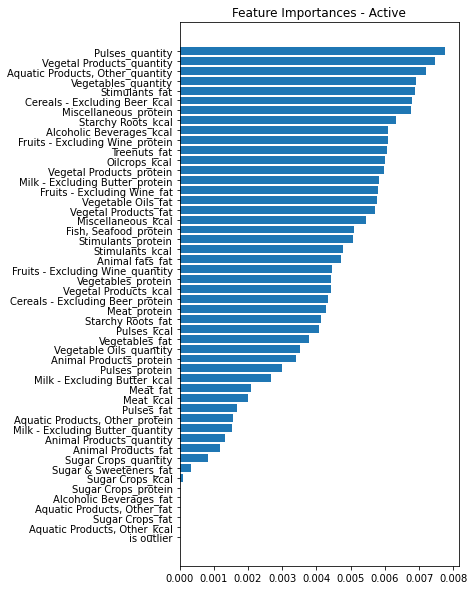

Pulses_quantity 0.007765672627049285
Vegetal Products_quantity 0.007468858833052139
Aquatic Products, Other_quantity 0.00720859629415307
Vegetables_quantity 0.006902034545089958
Stimulants_fat 0.006880374756207199
Cereals - Excluding Beer_kcal 0.006803178696804088
Miscellaneous_protein 0.0067745500312812925
Starchy Roots_kcal 0.006323704852099253
Alcoholic Beverages_kcal 0.006105071619969247
Fruits - Excluding Wine_protein 0.006079257780035302
Treenuts_fat 0.0060680278571700885
Oilcrops_kcal 0.00600297323190378
Vegetal Products_protein 0.005980838560897468
Milk - Excluding Butter_protein 0.005832207063975397
Fruits - Excluding Wine_fat 0.0058096359356484785
Vegetable Oils_fat 0.005778137709829726
Vegetal Products_fat 0.005721526771790586
Miscellaneous_kcal 0.005448928104837411
Fish, Seafood_protein 0.0050973303062289465
Stimulants_protein 0.005075880278946693
Stimulants_kcal 0.004762874627366076
Animal fats_fat 0.004726066546278666
Fruits - Excluding Wine_quantity 0.0044611962312499295

In [70]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.9, quantidade=19)


In [71]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Obesity 20
Undernourished 20
Confirmed 20
Deaths 20
Recovered 20
Active 20


<Figure size 432x288 with 0 Axes>

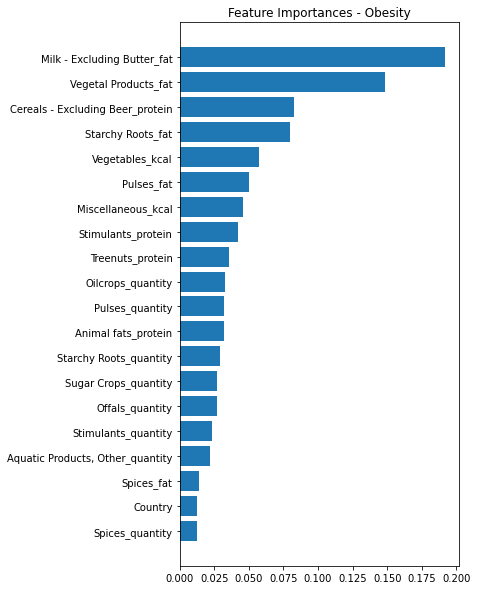

<Figure size 432x288 with 0 Axes>

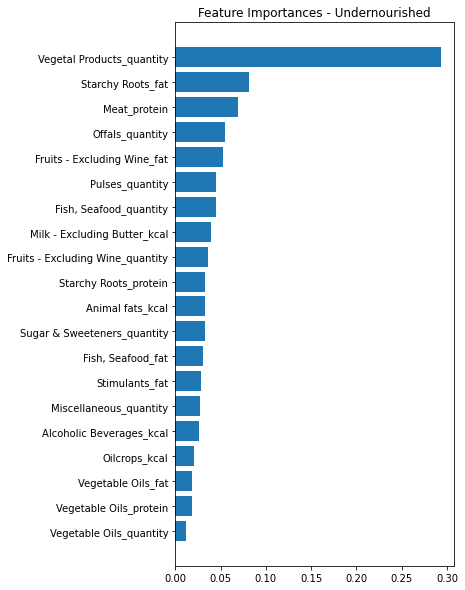

<Figure size 432x288 with 0 Axes>

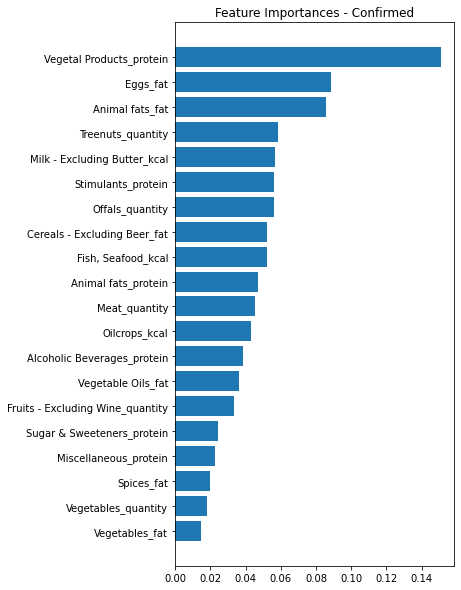

<Figure size 432x288 with 0 Axes>

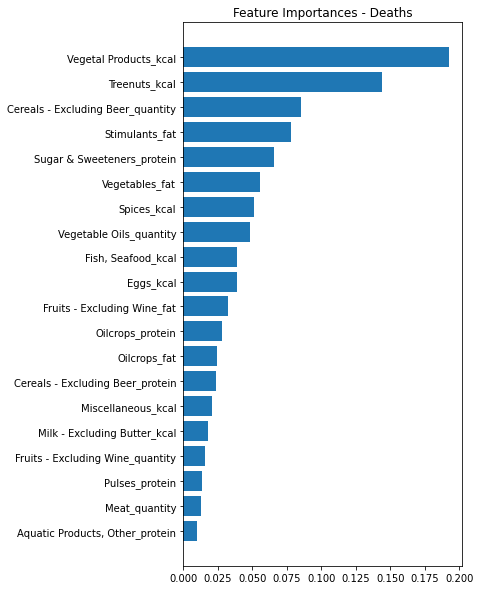

<Figure size 432x288 with 0 Axes>

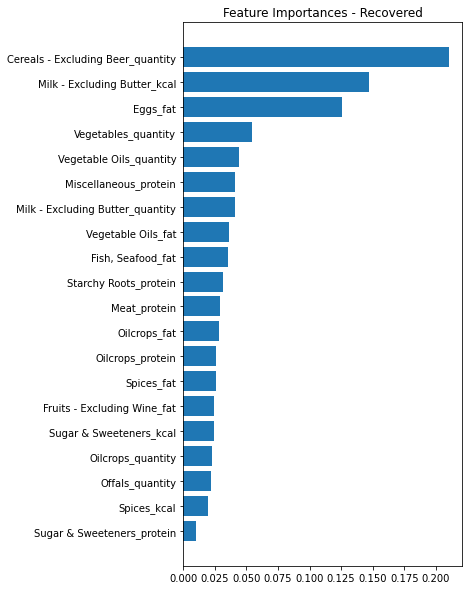

<Figure size 432x288 with 0 Axes>

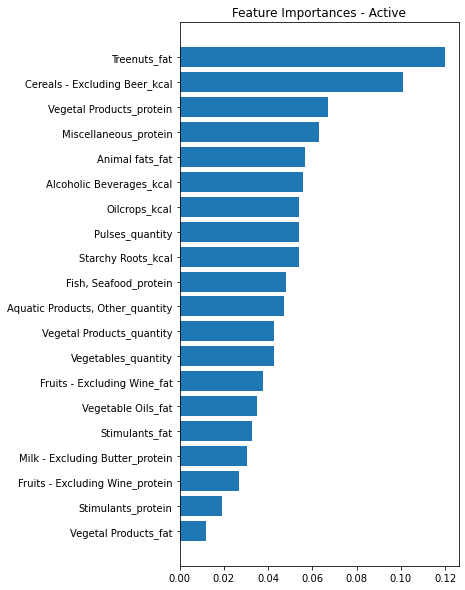

In [72]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

**TODO: usar leave one out, pois temos poucos dados**

In [73]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.5, random_state=42)

## Pré processamento

In [74]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Análise de sensibilidade

In [75]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

mae_scorer = make_scorer(mean_absolute_error)
mse_scorer = make_scorer(mean_squared_error)
msle_scorer = make_scorer(mean_squared_log_error)
r2_scorer = make_scorer(r2_score)

metrica = r2_scorer

**TODO: testar métricas diferentes --> erro relativo medio?**

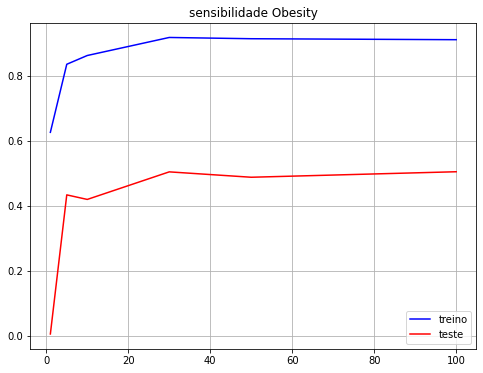

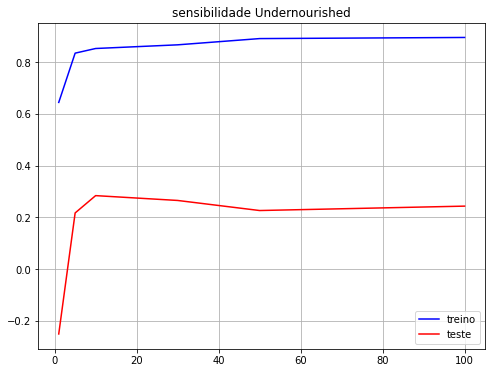

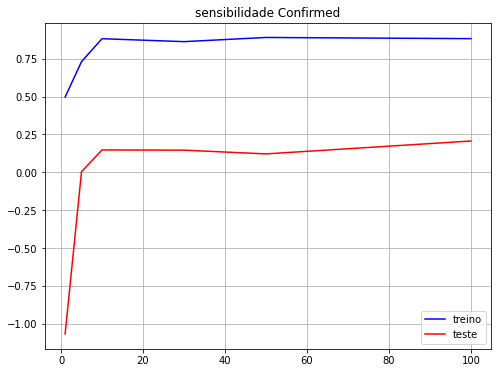

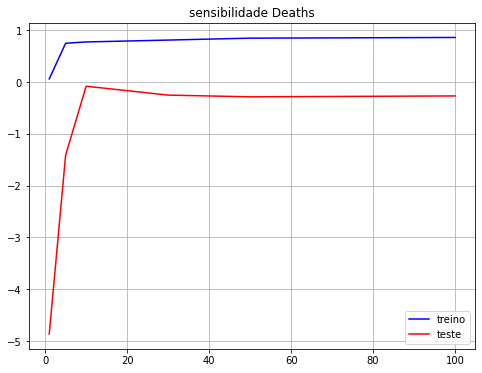

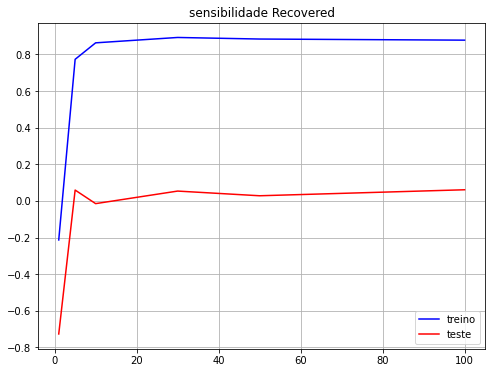

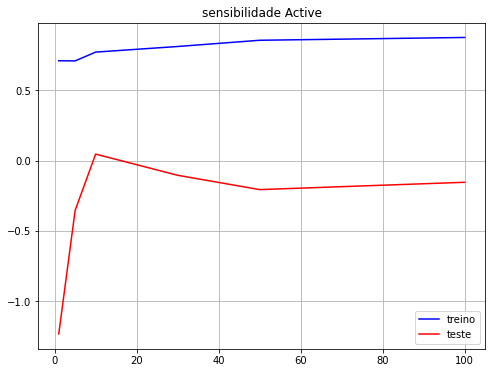

In [76]:
lista_n_arvores = [1, 5, 10, 30, 50, 100]

for t in targets:
    train_results = []
    test_results = []
    for n_arvores in lista_n_arvores:
        model = RandomForestRegressor(n_estimators=n_arvores,
                                 n_jobs = -1)
        
        model.fit(x_train_dict[t], y_train_dict[t])
        train_pred = model.predict(x_train_dict[t])
        test_pred = model.predict(x_test_dict[t])
        train_r2 = r2_score(y_train_dict[t], train_pred)
        test_r2 = r2_score(y_test_dict[t], test_pred)
        train_results.append(train_r2)
        test_results.append(test_r2)
    
    plt.figure(figsize=(8,6))
    plt.plot(lista_n_arvores, train_results, 'b', label="treino")
    plt.plot(lista_n_arvores, test_results, 'r', label="teste")
    plt.title('sensibilidade ' + t)
    plt.legend()
    plt.grid()

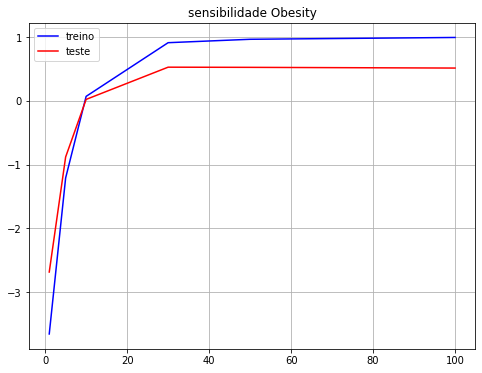

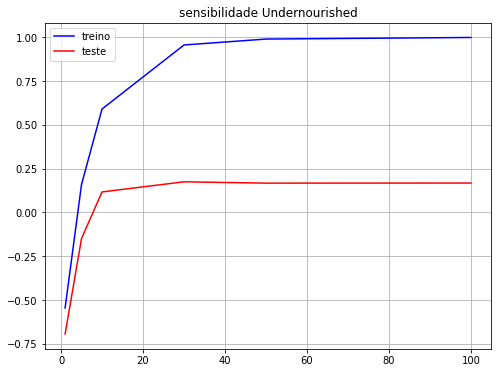

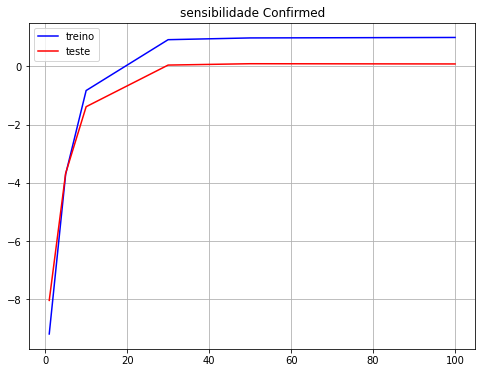

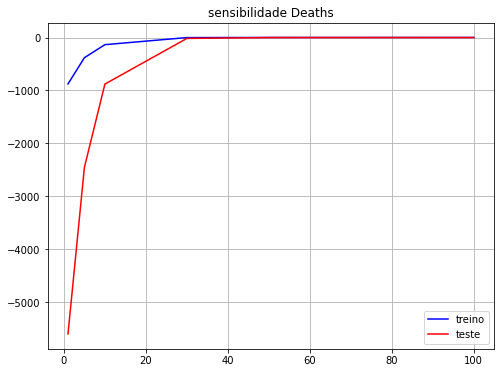

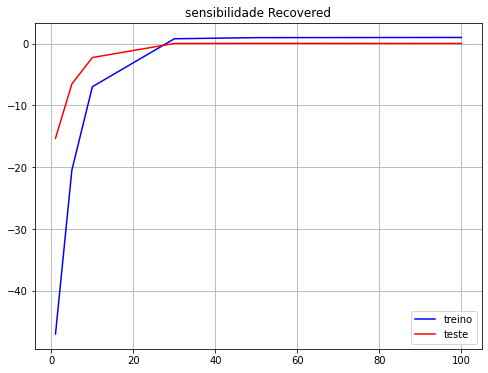

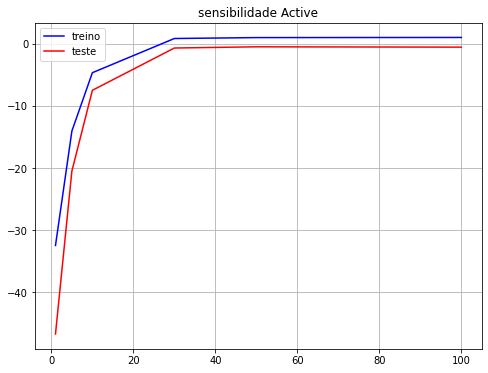

In [77]:
lista_n_arvores = [1, 5, 10, 30, 50, 100]

for t in targets:
    train_results = []
    test_results = []
    for n_arvores in lista_n_arvores:
        model = xgb.XGBRegressor(n_estimators=n_arvores,
                                 n_jobs = -1, objective='reg:squarederror')
        
        model.fit(x_train_dict[t], y_train_dict[t])
        train_pred = model.predict(x_train_dict[t])
        test_pred = model.predict(x_test_dict[t])
        train_r2 = r2_score(y_train_dict[t], train_pred)
        test_r2 = r2_score(y_test_dict[t], test_pred)
        train_results.append(train_r2)
        test_results.append(test_r2)
    
    plt.figure(figsize=(8,6))
    plt.plot(lista_n_arvores, train_results, 'b', label="treino")
    plt.plot(lista_n_arvores, test_results, 'r', label="teste")
    plt.title('sensibilidade ' + t)
    plt.legend()
    plt.grid()